In [2]:
import json
from redcap import Project
import pandas as pd
import numpy as np

api_url = 'https://redcap.case.edu/api/'
api_key = '6543B93BA07C88CFA3FD68E9692B1A87'

project = Project(api_url, api_key)
data = project.export_records()

In [3]:
# Q = neutral, P = angry

all_trials_data_a1 = []
all_trials_data_f1 = []

for record in data:
    record_id = record['record_id']

    try:
        trials_a1 = json.loads(record['flanker_data_json'])
        trials_f1 = json.loads(record['flanker_data_json_2'])
        for trial in trials_a1:
            all_trials_data_a1.append({
                'PPT': record_id,
                'trial': trial['trial'],
                'response': trial['response'],
                'Correct': 1.0 if trial['accuracy'] else 0.0,
                'RT': trial['duration'] / 1000,
                'Congruency': 0 if trial['congruency'] == 'c' else 1
            })
        for trial in trials_f1:
            all_trials_data_f1.append({
                'PPT': record_id,
                'trial': trial['trial'],
                'response': trial['response'],
                'Correct': 1.0 if trial['accuracy'] else 0.0,
                'RT': trial['duration'] / 1000,
                'Congruency': 0 if trial['congruency'] == 'c' else 1,
                'faces': trial['faces']
            })
    except json.JSONDecodeError:
        print(f"Error decoding JSON for record {record_id}")
    except Exception as e:
        print(f"Unexpected error for record {record_id}: {e}")

df_a1 = pd.DataFrame(all_trials_data_a1)
df_a1 = df_a1[~((df_a1['RT'] == 2) & (df_a1['Correct'] == 0.0) & ((df_a1['response'] != 'P') | (df_a1['response'] != 'Q')))]
df_a1 = df_a1[~(df_a1['RT'] < 0.15)]
# df_a1.to_csv('A1_data.csv')
df_f1 = pd.DataFrame(all_trials_data_f1)
df_f1 = df_f1[~((df_f1['RT'] == 2) & (df_f1['Correct'] == 0.0) & ((df_f1['response'] != 'P') | (df_f1['response'] != 'Q')) & (df_f1['trial'] != 1))]
# df_f1.to_csv('F1_data.csv')
df_r = df_f1.copy()
# Neutral trials only - what is the Black-Anger bias?
# df_r = df_r[((df_r['response'] == 'P') & (df_r['Correct'] == 0.0)) | ((df_r['response'] == 'Q') & (df_r['Correct'] == 1.0))]
df_r['faces'] = [1 if x=='BF' else 0 for x in df_r['faces']]
df_r['emotion'] = df_r.apply(lambda x: 0 if ((x['response'] == 'P' and x['Correct'] == 0.0) or 
                                             (x['response'] == 'Q' and x['Correct'] == 1.0)) else 1, axis=1)
df_r['condition'] = df_r.apply(lambda x: f"{x['emotion']}-{x['faces']}-{x['Congruency']}", axis=1)
df_r.to_csv('flexddm/data/F1_data.csv')

df_r

Error decoding JSON for record 1
Error decoding JSON for record 3
Error decoding JSON for record 9
Error decoding JSON for record 10
Error decoding JSON for record 11
Error decoding JSON for record 12
Error decoding JSON for record 17
Error decoding JSON for record 24
Error decoding JSON for record 25
Error decoding JSON for record 48
Error decoding JSON for record 54
Error decoding JSON for record 57
Error decoding JSON for record 58
Error decoding JSON for record 62
Error decoding JSON for record 71
Error decoding JSON for record 74
Error decoding JSON for record 79
Error decoding JSON for record 82
Error decoding JSON for record 89
Error decoding JSON for record 96
Error decoding JSON for record 99
Error decoding JSON for record 100
Error decoding JSON for record 101
Error decoding JSON for record 102
Error decoding JSON for record 103
Error decoding JSON for record 106
Error decoding JSON for record 109
Error decoding JSON for record 110
Error decoding JSON for record 111
Error dec

,PPT,trial,response,Correct,RT,Congruency,faces,emotion,condition
0,2,1,P,1.0,1.311,1,0,1,1-0-1
1,2,2,P,0.0,0.998,1,0,0,0-0-1
2,2,3,Q,1.0,1.321,1,0,0,0-0-1
3,2,4,Q,1.0,1.100,0,0,0,0-0-0
4,2,5,P,1.0,0.762,0,1,1,1-1-0
...,...,...,...,...,...,...,...,...,...
19763,130,199,P,1.0,1.166,0,0,1,1-0-0
19764,130,200,Q,1.0,0.850,0,1,0,0-1-0
19765,130,201,P,1.0,1.058,1,0,1,1-0-1
19766,130,202,P,1.0,0.705,1,1,1,1-1-1


In [145]:
df = pd.read_csv('F1_data.csv')
filtered_df = df[df["PPT"] == 97]
proportion_correct = filtered_df["Correct"].sum() / len(filtered_df)
print(f"Proportion of correct responses for PPT: {proportion_correct:.2f}")

Proportion of correct responses for PPT: 0.78


In [4]:
import scipy.stats as stats

df_n = pd.read_csv('mDMCfs_output_neutral.csv')
df_a = pd.read_csv('mDMCfs_output_arrow.csv')

arrowlist = ['alpha', 'beta', 'eta', 'eta_r', 'characteristic_time', 'peak_amplitude', 'tau']
for x in arrowlist:
    df_n['%s_arrow' % x] = df_a[x]


macarthur = []
abarratt_attention = []
abarratt_motor = []
abarratt_nonplanning = []
vardict = {}
varlist = ['macarthur', 'abarratt_attention', 'abarratt_motor', 'abarratt_nonplanning',
           'aps_frequency', 'aps_duration', 'aps_intensity', 'aps_threshold', 'aps_latency',
           'bpaqsf_physical_aggression', 'bpaqsf_verbal_aggression', 'bpaqsf_anger', 'bpaqsf_hostility',
           'er_cr_total', 'er_es_total',
           'sdo_d_score', 'sdo_e_score', 'sdo_score',
           'cobras_racial_privilege', 'cobras_discrimination', 'cobras_racial_issues', 
           ]
for x in varlist:
    vardict[x] = []

for record in data:
    record_id = record['record_id']
    if int(record_id) in list(df_a['id'].unique()):
        for x in varlist:
            vardict[x].append(float(record[x]))

for x in varlist:
    df_n[x] = vardict[x]

correlation_matrix = df_n.corr()

# Function to calculate p-values
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    pvalues = pd.DataFrame(data=np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for row in df.columns:
        for col in df.columns:
            if row != col:
                pvalues.loc[row, col] = stats.pearsonr(df[row], df[col])[1]
            else:
                pvalues.loc[row, col] = np.nan
    return pvalues

# Calculate p-values
pvalues = calculate_pvalues(df_n)

# Combine correlation matrix and p-values
result = correlation_matrix.copy()
for col in correlation_matrix.columns:
    result[col] = list(zip(correlation_matrix[col], pvalues[col]))

# Display the result
for column in result.columns:
    # print(result[column])
    filtered_rows = result[column][result[column].apply(lambda x: x[1] < 0.1)]
    print(f"Column: {column}")
    print(filtered_rows)
    print('\n')

Column: id
alpha                      (-0.38649126978844495, 0.09231866833172034)
eta                         (0.44633388504622623, 0.04853219733775993)
eta_r                        (0.465433558098774, 0.038635805050742565)
tau                        (0.44286402472967046, 0.050521505580436936)
eta_r_arrow                 (0.4579213024561793, 0.042321580825139885)
macarthur                    (0.4005978515740977, 0.08006026002790771)
aps_intensity               (0.38269982544284903, 0.09583611666429295)
sdo_e_score                  (0.4750707667221421, 0.03427778077223855)
sdo_score                    (0.4714228143891751, 0.03587982071404841)
cobras_racial_privilege     (0.5721909842292605, 0.008381925616252058)
cobras_discrimination      (0.6655880009178318, 0.0013598904079886315)
cobras_racial_issues          (0.4776346770721095, 0.0331856117262955)
Name: id, dtype: object


Column: alpha
id                      (-0.38649126978844495, 0.09231866833172034)
eta_r                   (-0.5

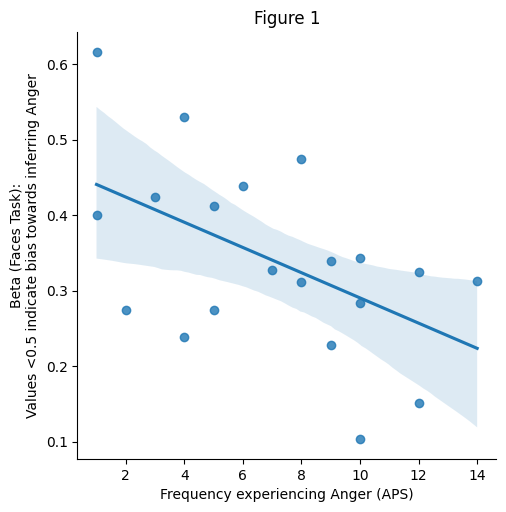

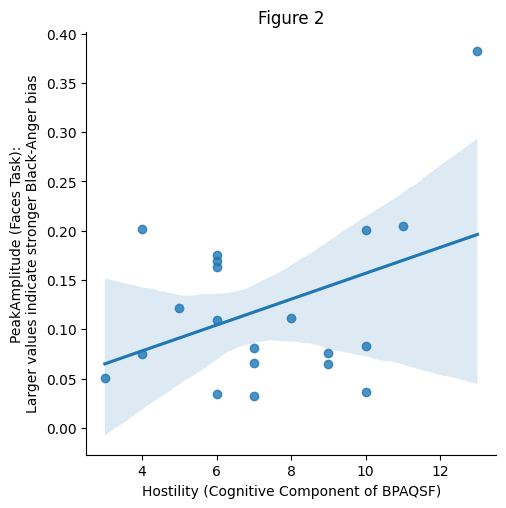

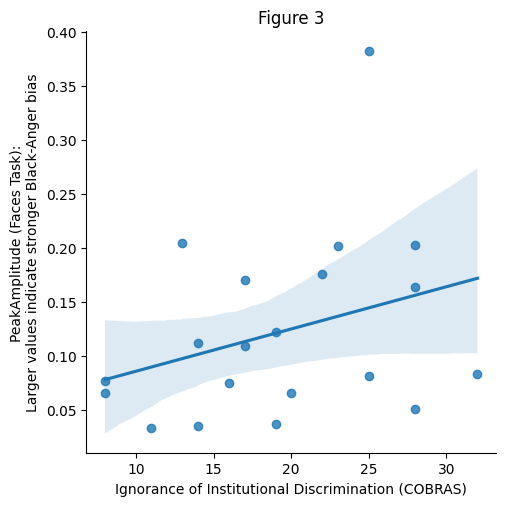

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,eta_r_arrow ~ X,-0.252133,0.159976,0.132423,-0.588231,0.083965,No
1,Y ~ eta_r_arrow,0.021230,0.007368,0.009934,0.005751,0.036709,Yes
2,Total,-0.014882,0.005411,0.013161,-0.026250,-0.003514,Yes
3,Direct,-0.010845,0.005232,0.053702,-0.021883,0.000193,No
4,Indirect,-0.004038,0.003586,0.148000,-0.013026,0.000883,No


In [7]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pingouin import mediation_analysis

# sns.lmplot(data=df_n, x='bpaqsf_anger', y='beta')
# plt.xlabel('Anger (Affective Component of BPAQSF)')
# plt.ylabel('Beta (Faces Task):\nValues <0.5 indicate bias towards inferring Anger')
# plt.show()

sns.lmplot(data=df_n, x='aps_frequency', y='beta')
plt.xlabel('Frequency experiencing Anger (APS)')
plt.ylabel('Beta (Faces Task):\nValues <0.5 indicate bias towards inferring Anger')
plt.title('Figure 1')
plt.show()

# sns.lmplot(data=df_n, x='bpaqsf_hostility', y='beta')
# plt.xlabel('Hostility (Cognitive Component of BPAQSF)')
# plt.ylabel('Beta (Faces Task):\nValues <0.5 indicate bias towards inferring Anger')
# plt.show()

sns.lmplot(data=df_n, x='bpaqsf_hostility', y='peak_amplitude')
plt.xlabel('Hostility (Cognitive Component of BPAQSF)')
plt.ylabel('PeakAmplitude (Faces Task):\nLarger values indicate stronger Black-Anger bias')
plt.title('Figure 2')
plt.show()

sns.lmplot(data=df_n, x='cobras_discrimination', y='peak_amplitude')
plt.xlabel('Ignorance of Institutional Discrimination (COBRAS)')
plt.ylabel('PeakAmplitude (Faces Task):\nLarger values indicate stronger Black-Anger bias')
plt.title('Figure 3')
plt.show()

# mediation_analysis(data=df_n, x='bpaqsf_hostility', m='alpha_arrow', y='peak_amplitude')
mediation_analysis(data=df_n, x='aps_threshold', m='eta_r_arrow', y='beta')

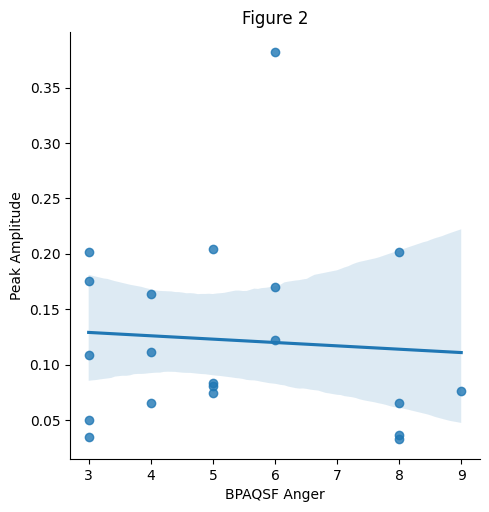

In [30]:
sns.lmplot(data=df_n, x='bpaqsf_anger', y='peak_amplitude')
plt.xlabel('BPAQSF Anger')
plt.ylabel('Peak Amplitude')
plt.title('Figure 2')
plt.show()

In [69]:
model_y

C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3960164710.py:18: RuntimeWarning: divide by zero encountered in divide
  np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3960164710.py:17: RuntimeWarning: invalid value encountered in multiply
  automatic_up = start + (peak_amplitude * np.exp(-(t / characteristic_time)) *
C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3960164710.py:20: RuntimeWarning: divide by zero encountered in divide
  np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3960164710.py:19: RuntimeWarning: invalid value encountered in multiply
  automatic_down = start + (-peak_amplitude * np.exp(-(t / characteristic_time)) *


Text(0, 0.5, 'Evidence')

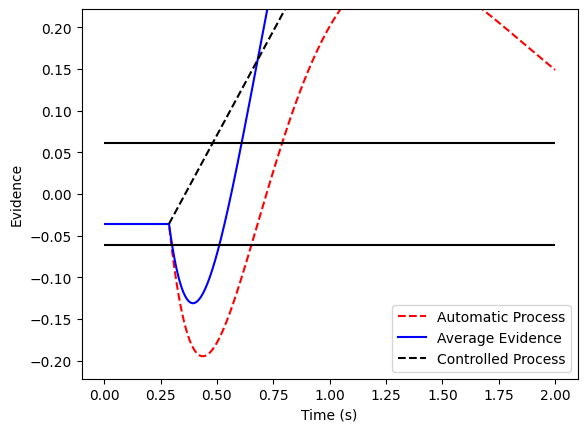

In [27]:
import numpy as np
import matplotlib.pyplot as plt

peak_amplitude = 0.362321930732661
characteristic_time = 0.393173013819168
shape = 2
mu_c = 0.5
# mu_c = 5
tau = 0.287315341005565
alpha =0.121588204059417
beta = 0.204370870822864
t_max = 2

t = np.linspace(0, t_max-tau, 1000)
start = beta*alpha/2 - (1-beta)*alpha/2
controlled = t*mu_c + start
automatic_up = start + (peak_amplitude * np.exp(-(t / characteristic_time)) *
                            np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
automatic_down = start + (-peak_amplitude * np.exp(-(t / characteristic_time)) *
                            np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
drift_down = (controlled-start) + automatic_down
drift_down[0] = start
newt = np.linspace(0+tau, t_max, 1000)
# plt.plot(newt, automatic_up)
plt.plot(newt, automatic_down, linestyle='--', color='red', label='Automatic Process')
plt.plot(newt, drift_down, color='blue', label='Average Evidence')
plt.plot(newt, controlled, linestyle='--', color='black', label='Controlled Process')

plt.hlines(y=alpha/2, xmin=0, xmax=t_max, color='black')
plt.hlines(y=-alpha/2, xmin=0, xmax=t_max, color='black')
plt.hlines(y=start, xmin=0, xmax=tau, color='blue')

# plt.xlim(0, newt[np.argwhere(np.array(drift_down)>alpha)[0][0]])
plt.ylim(-alpha-0.1, alpha+0.1)
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('Evidence')

C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3286116985.py:18: RuntimeWarning: divide by zero encountered in divide
  np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3286116985.py:17: RuntimeWarning: invalid value encountered in multiply
  automatic_up = start + (peak_amplitude * np.exp(-(t / characteristic_time)) *
C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3286116985.py:20: RuntimeWarning: divide by zero encountered in divide
  np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
C:\Users\kjl113\AppData\Local\Temp\ipykernel_3876\3286116985.py:19: RuntimeWarning: invalid value encountered in multiply
  automatic_down = start + (-peak_amplitude * np.exp(-(t / characteristic_time)) *


Text(0, 0.5, 'Evidence')

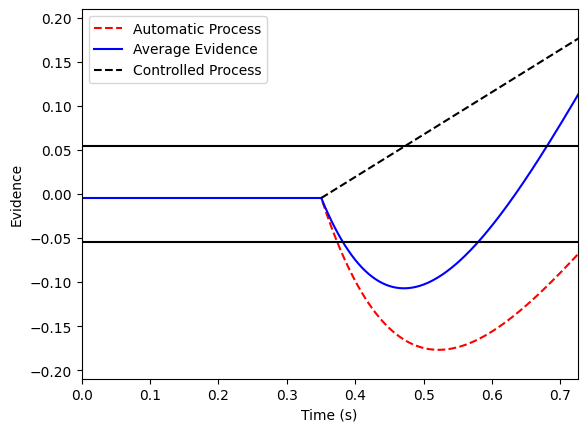

In [23]:
import numpy as np
import matplotlib.pyplot as plt

peak_amplitude = 0.393238271689313
characteristic_time = 0.449225132386467
shape = 2
mu_c = 0.481571296206275
# mu_c = 48
tau = 0.350352186476851
alpha = 0.109658551057361
beta = 0.457592954672543
t_max = 2

t = np.linspace(0, t_max-tau, 1000)
start = beta*alpha/2 - (1-beta)*alpha/2
controlled = t*mu_c + start
automatic_up = start + (peak_amplitude * np.exp(-(t / characteristic_time)) *
                            np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
automatic_down = start + (-peak_amplitude * np.exp(-(t / characteristic_time)) *
                            np.power(((t * np.exp(1)) / ((shape - 1) * characteristic_time)), (shape - 1)) * (((shape - 1) / t) - (1 / characteristic_time)))*t
drift_down = (controlled-start) + automatic_down
drift_down[0] = start
newt = np.linspace(0+tau, t_max, 1000)
# plt.plot(newt, automatic_up)
plt.plot(newt, automatic_down, linestyle='--', color='red', label='Automatic Process')
plt.plot(newt, drift_down, color='blue', label='Average Evidence')
plt.plot(newt, controlled, linestyle='--', color='black', label='Controlled Process')

plt.hlines(y=alpha/2, xmin=0, xmax=t_max, color='black')
plt.hlines(y=-alpha/2, xmin=0, xmax=t_max, color='black')
plt.hlines(y=start, xmin=0, xmax=tau, color='blue')

plt.xlim(0, newt[np.argwhere(np.array(drift_down)>alpha)[0][0]])
plt.ylim(-alpha-0.1, alpha+0.1)
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('Evidence')